In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

In [2]:
# Load the dataset
file_path = "C:/Users/Jose Guevara/Desktop/Kaggle/2024 Boston Marathon Weather and Splits/Datasets/Merged_Athletes_and_Weather_Data.csv"
data = pd.read_csv(file_path)

In [3]:
# Encode Gender: M = 1, F = 0
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)
data.drop(columns=['First Half', 'Second Half', 'Positive Split', 'Percent Change'], inplace=True)

In [4]:
# Categorize 'Age Group'
age_group_mapping = {
    'Under 35': 0,
    '35-39': 1,
    '40-44': 2,
    '45-49': 3,
    '50-54': 4,
    '55-59': 5,
    '60-64': 6,
    '65-69': 7,
    '70-74': 8,
    '75-79': 9,
    '80 and Over': 10
}
data['Age Group'] = data['Age Group'].map(age_group_mapping)

# Set 'Bib' as index
data.set_index(['Bib'], inplace=True)

# Drop rows with missing values
data_cleaned = data.dropna()

In [5]:
# Separate numerical and categorical features
numerical_features = data_cleaned.drop(columns=['Finish', 'Age Group']).columns
categorical_features = ['Age Group']

#Apply MinMaxScaler only to numerical features
# scaler = MinMaxScaler()
# data_cleaned[numerical_features] = scaler.fit_transform(data_cleaned[numerical_features])

# Split the data into features and target
X_cleaned = data_cleaned.drop(columns=['Finish'])
y_cleaned = data_cleaned['Finish']


In [6]:
# Split the cleaned and scaled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Convert to DataFrame to preserve feature names
X_train_df = pd.DataFrame(X_train, columns=X_cleaned.columns)
X_test_df = pd.DataFrame(X_test, columns=X_cleaned.columns)

# Define a function to print model performance
def print_model_performance(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Model\n")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("\n")

# Random Forest Regression Model with Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 400, 750],
    'max_depth': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 20]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=10, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)
y_pred_rf = rf_grid_search.predict(X_test)
print_model_performance("Random Forest Regression", y_test, y_pred_rf)

# XGBoost Regression Model with Hyperparameter Tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 400, 750],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.7, 1.0]
}

xgb_grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), xgb_param_grid, cv=10, n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)
y_pred_xgb = xgb_grid_search.predict(X_test)
print_model_performance("XGBoost Regression", y_test, y_pred_xgb)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Random Forest Regression Model

RMSE: 2501.0563590083075
MAE: 1889.9504293829


Fitting 10 folds for each of 192 candidates, totalling 1920 fits
XGBoost Regression Model

RMSE: 2509.5324400324944
MAE: 1890.184261640375




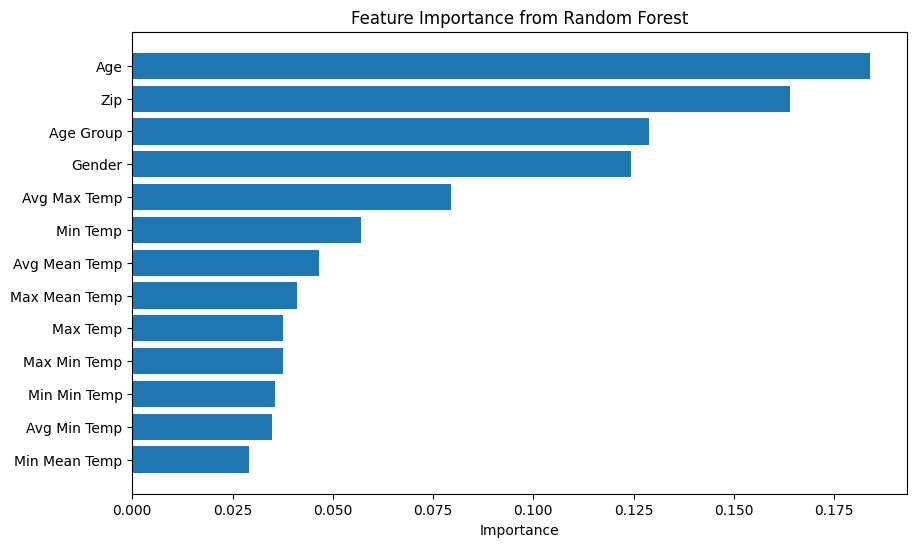

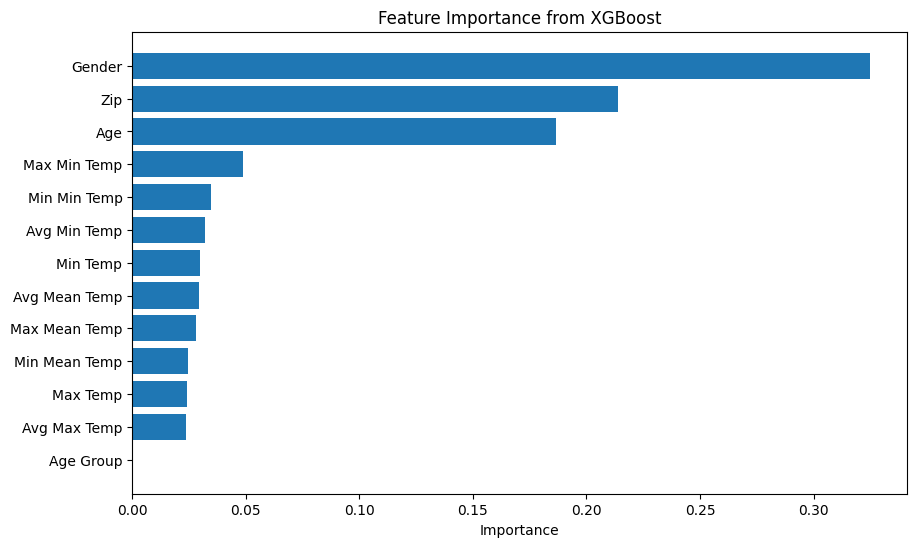

In [7]:
# Feature Importance from Random Forest
rf_feature_importance = rf_grid_search.best_estimator_.feature_importances_
rf_features = X_cleaned.columns
rf_importance_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_feature_importance}).sort_values(by='Importance', ascending=False)

# Plotting Feature Importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Feature Importance from XGBoost
xgb_feature_importance = xgb_grid_search.best_estimator_.feature_importances_
xgb_features = X_cleaned.columns
xgb_importance_df = pd.DataFrame({'Feature': xgb_features, 'Importance': xgb_feature_importance}).sort_values(by='Importance', ascending=False)

# Plotting Feature Importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

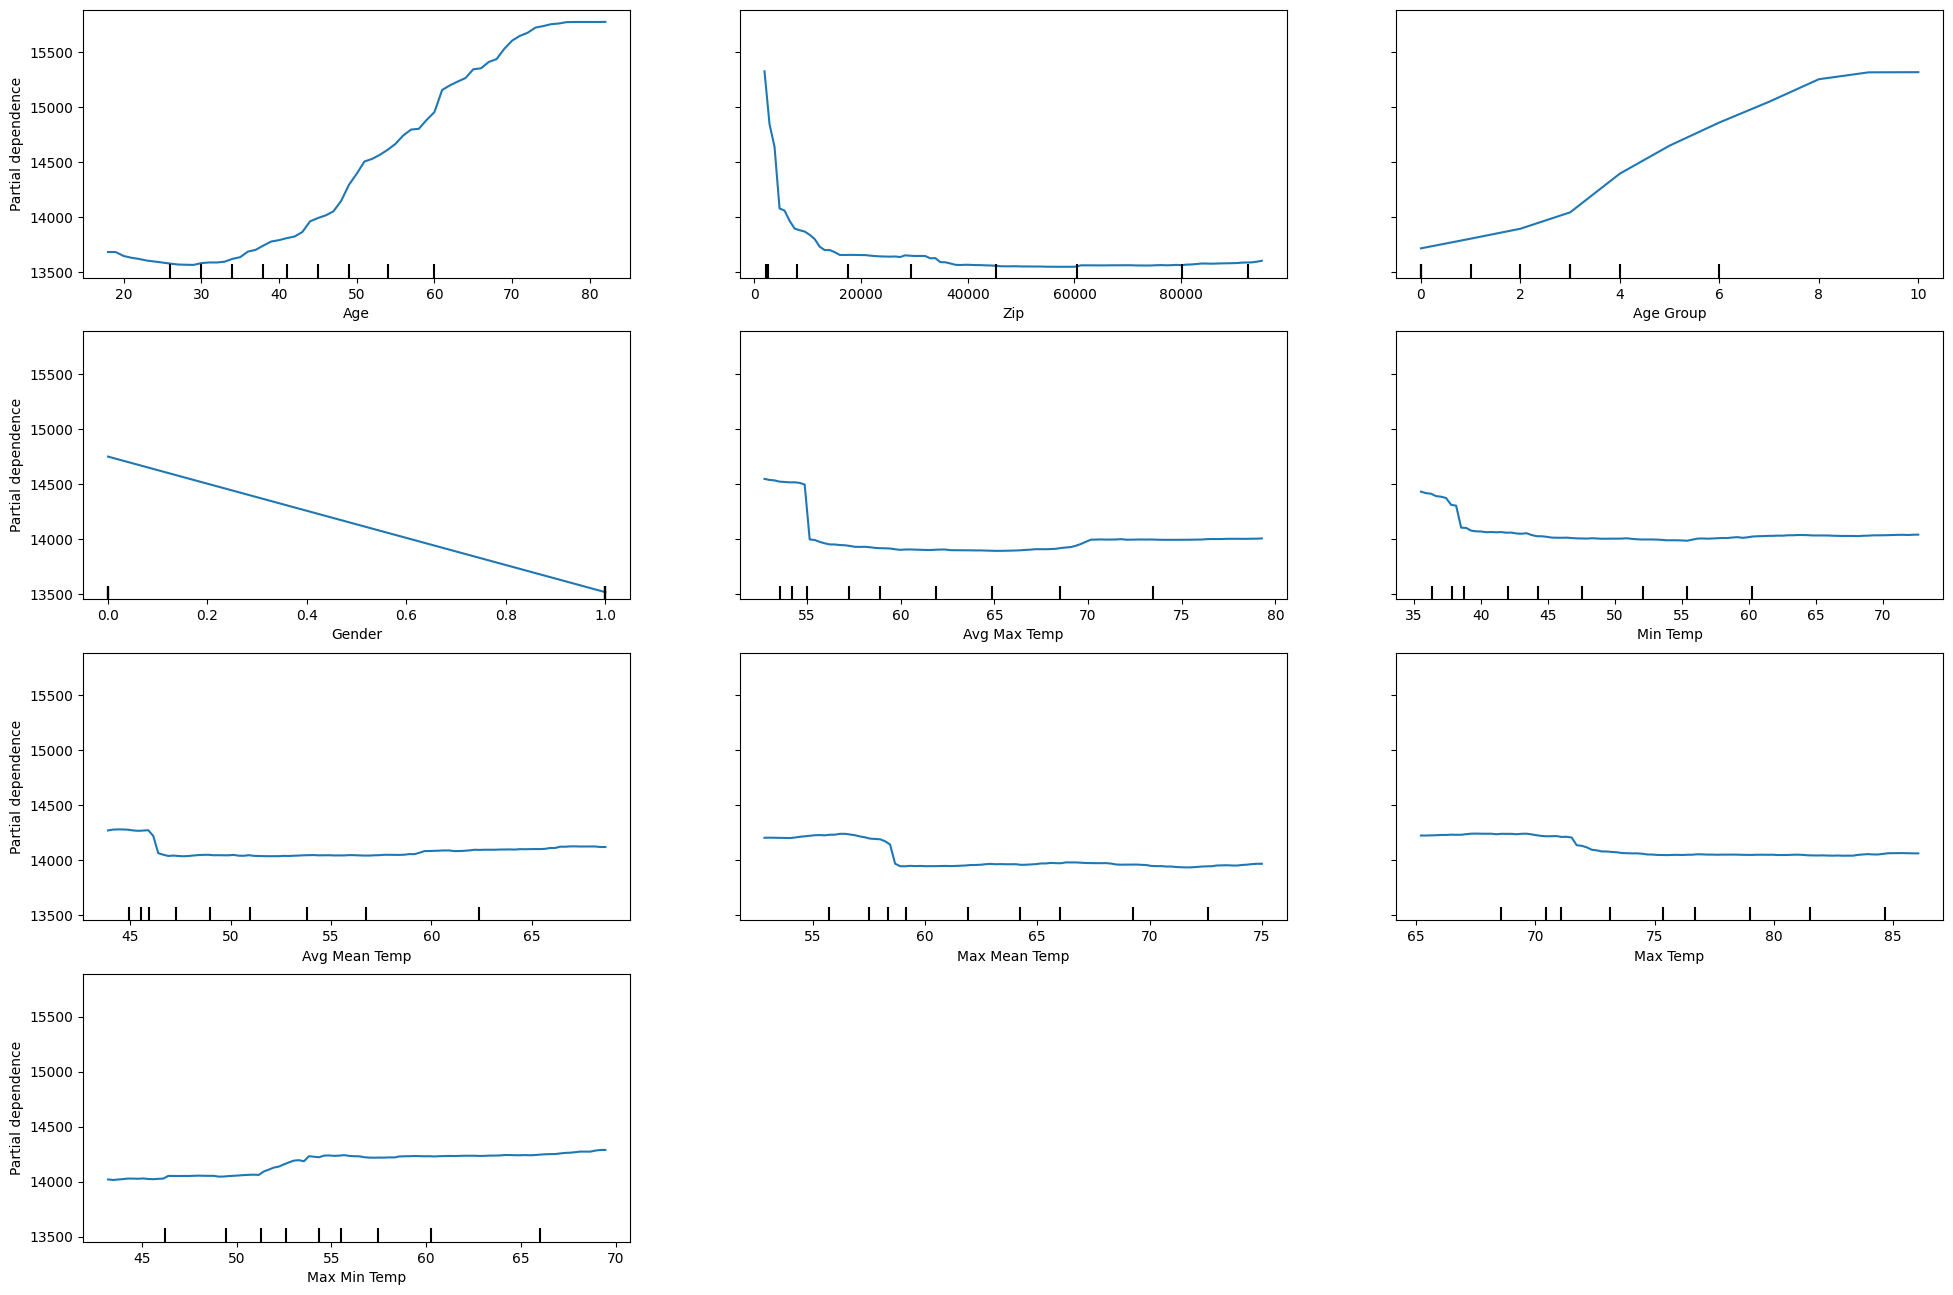

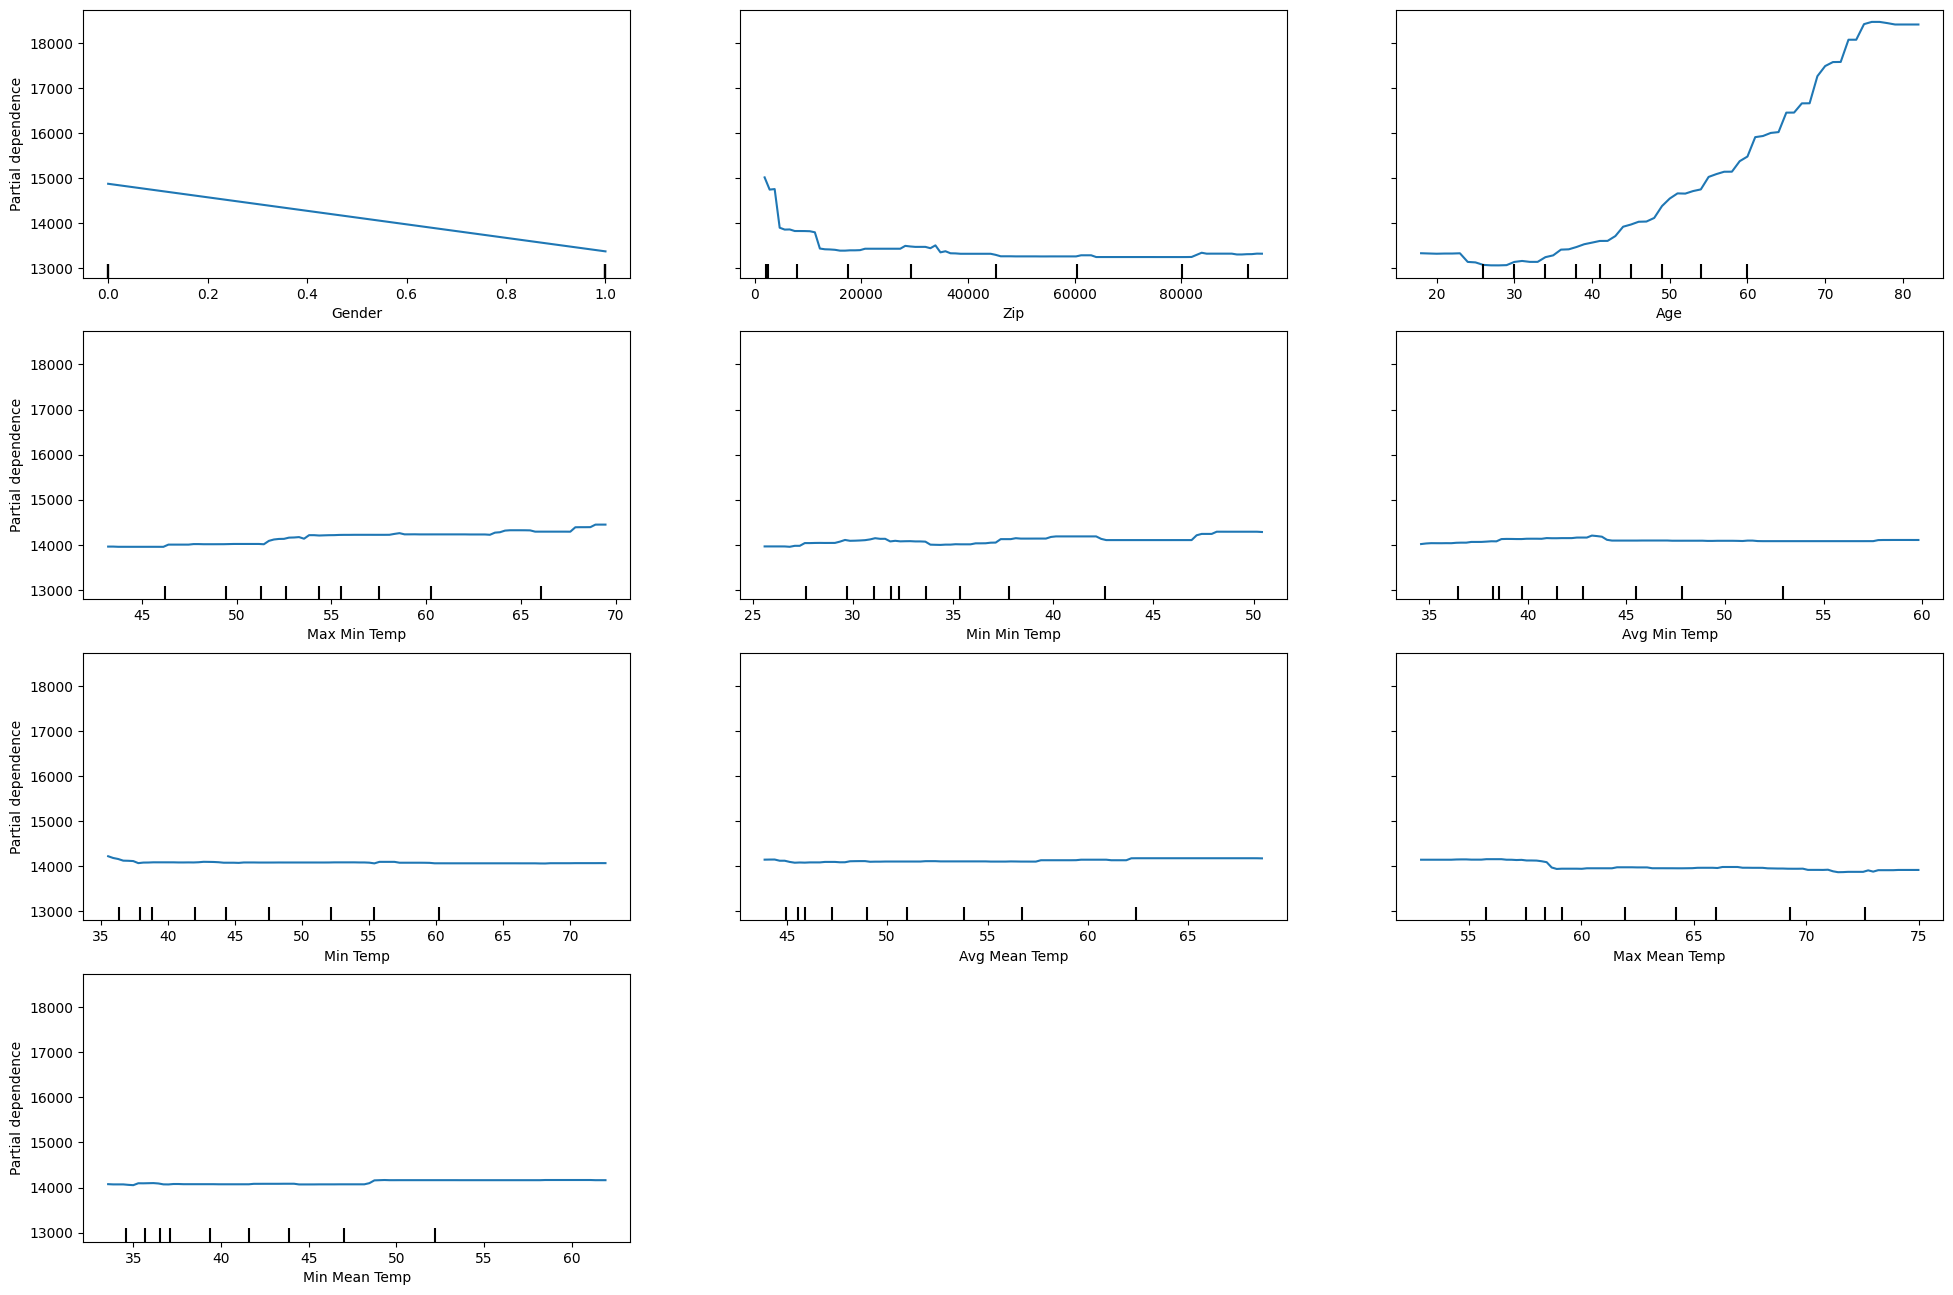

In [8]:
# Partial Dependence Plot for the top 10 features (Random Forest)
top_rf_features = rf_importance_df['Feature'].head(10).tolist()
fig, ax = plt.subplots(figsize=(24, 16))
PartialDependenceDisplay.from_estimator(rf_grid_search.best_estimator_, X_train, features=top_rf_features, ax=ax)
plt.show()

# Partial Dependence Plot for the top 10 features (XGBoost)
top_xgb_features = xgb_importance_df['Feature'].head(10).tolist()
fig, ax = plt.subplots(figsize=(24, 16))
PartialDependenceDisplay.from_estimator(xgb_grid_search.best_estimator_, X_train, features=top_xgb_features, ax=ax)
plt.show()

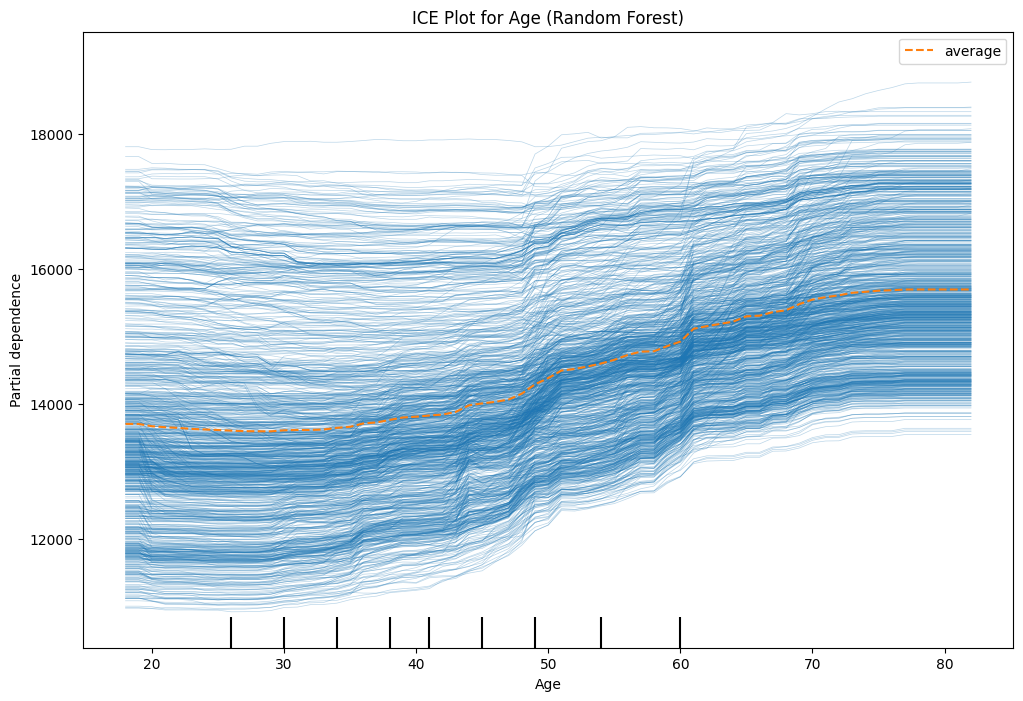

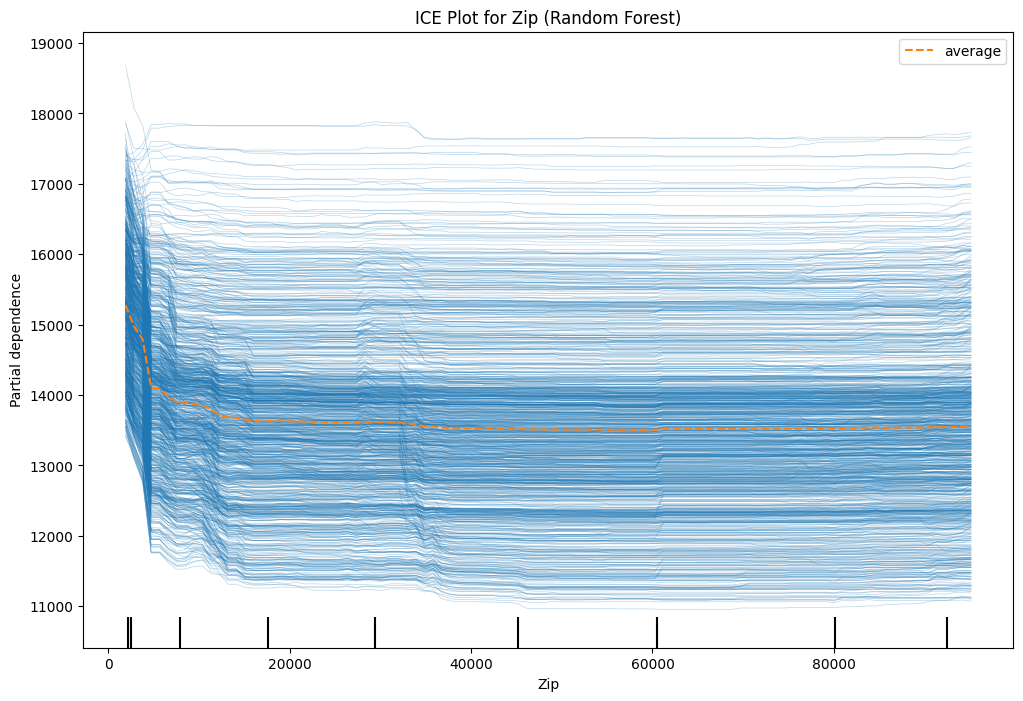

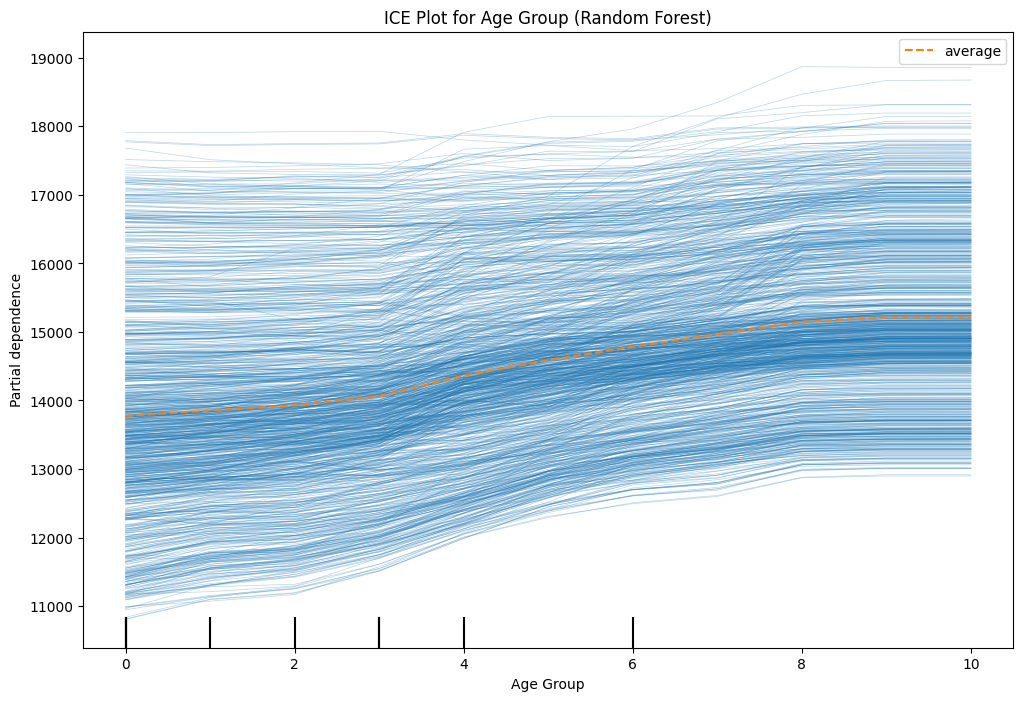

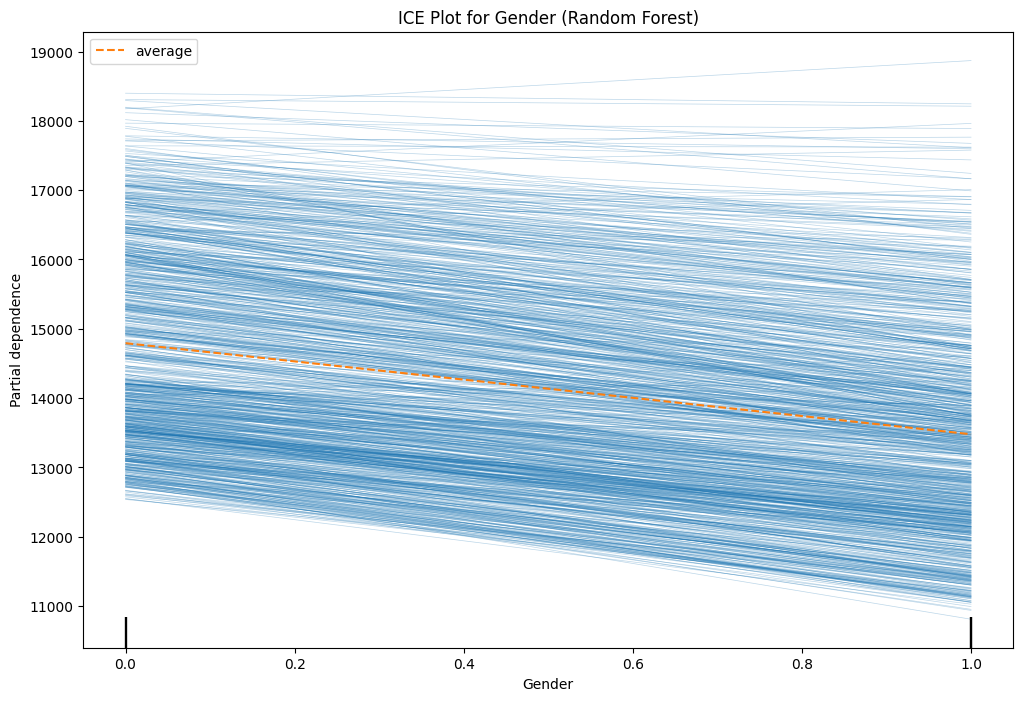

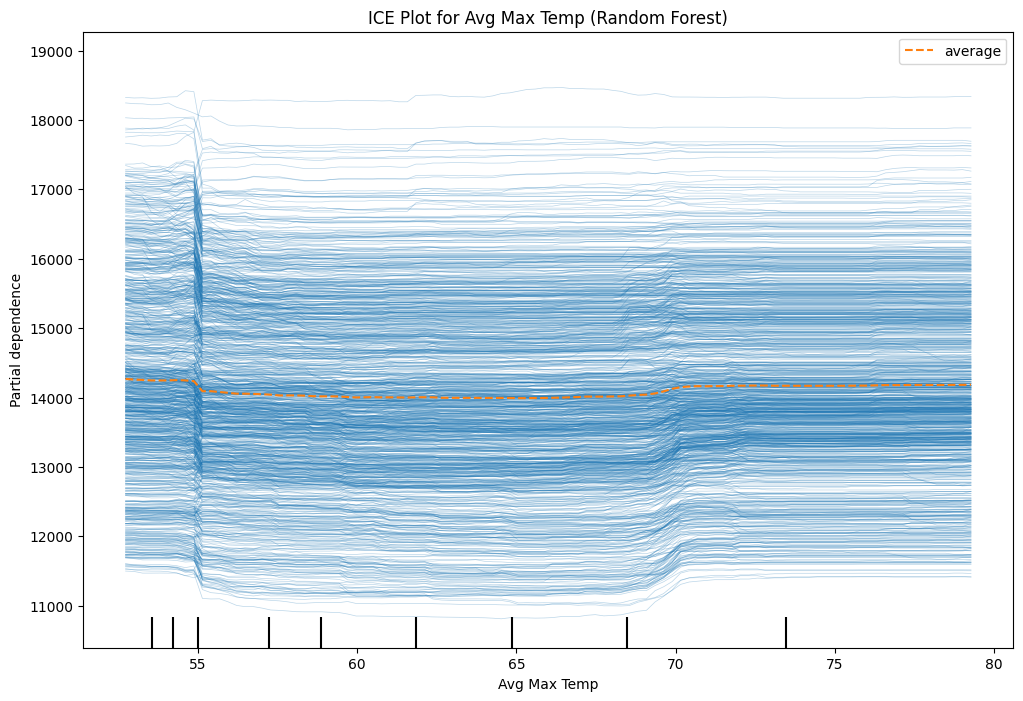

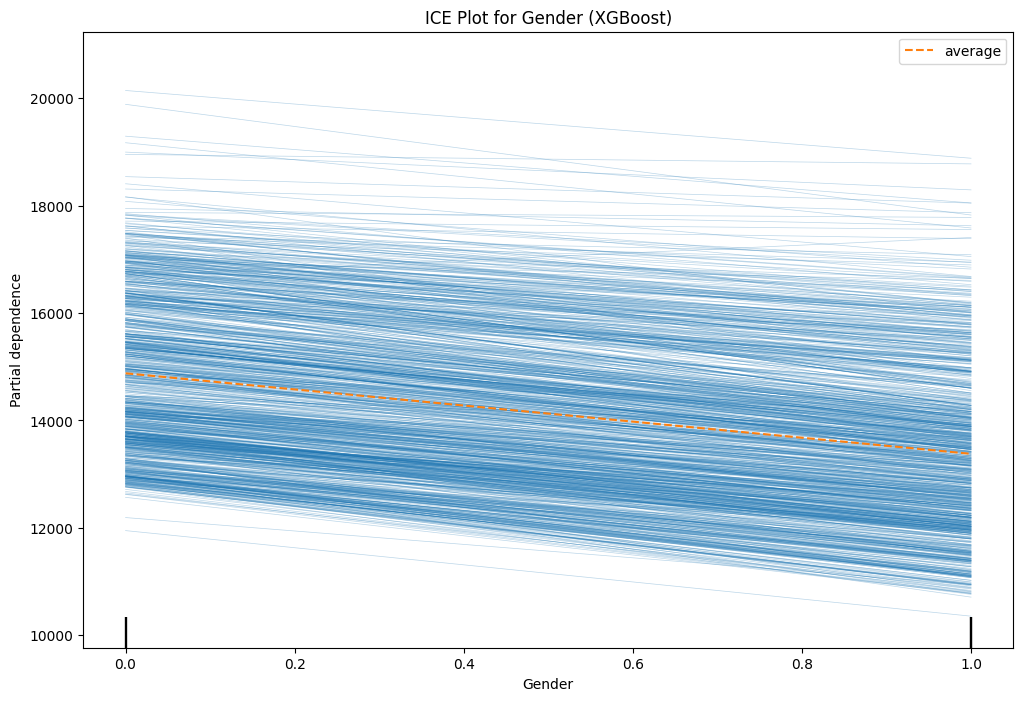

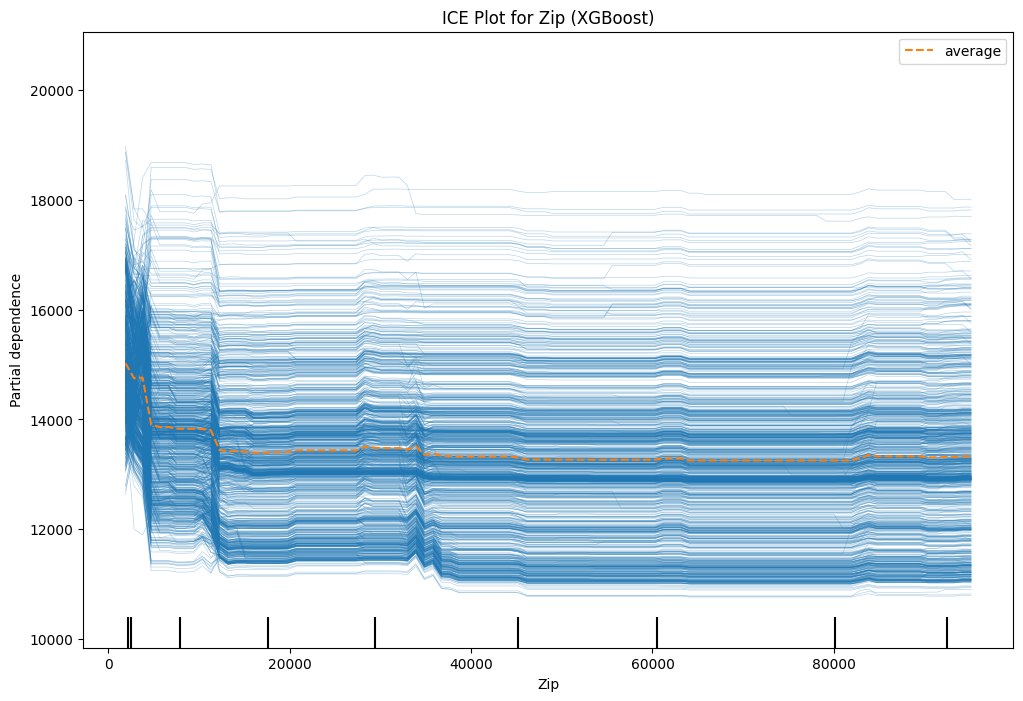

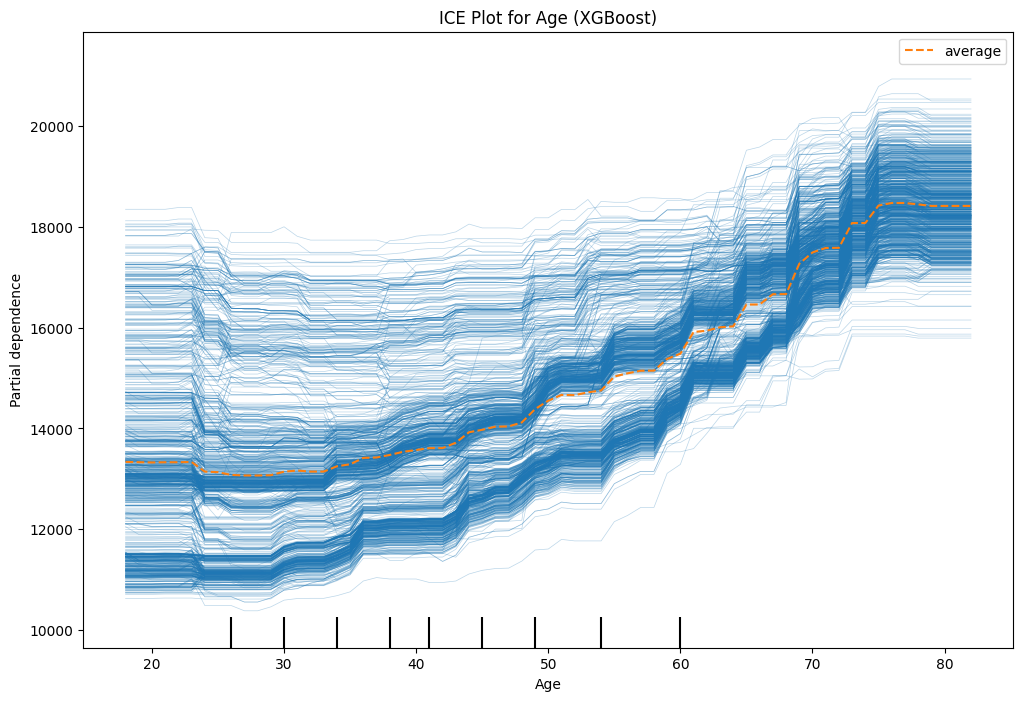

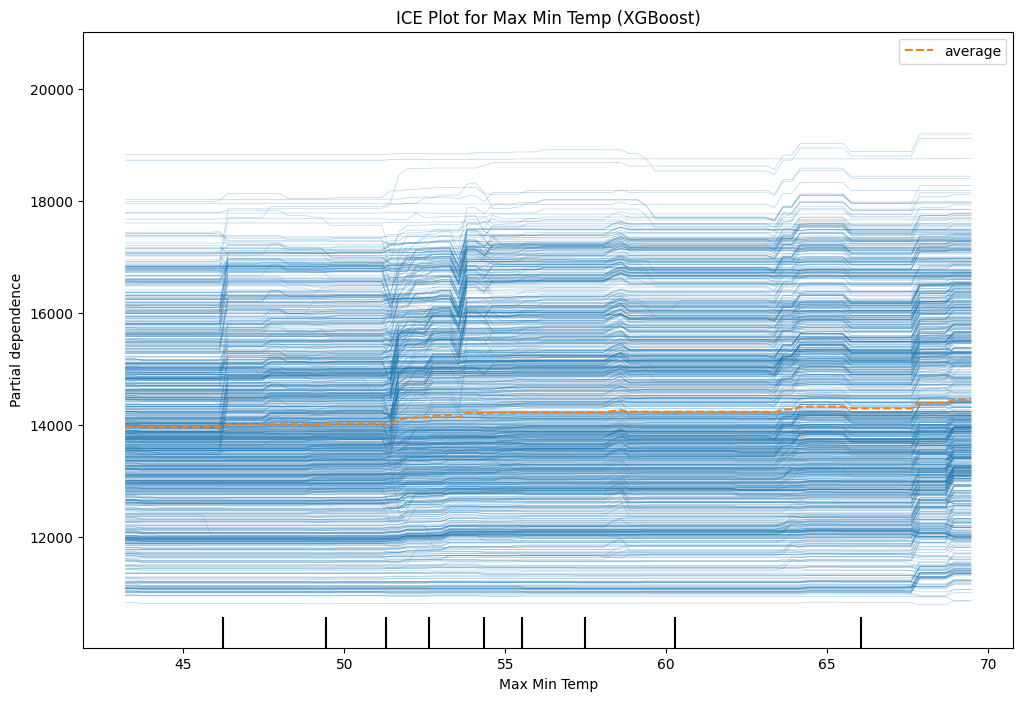

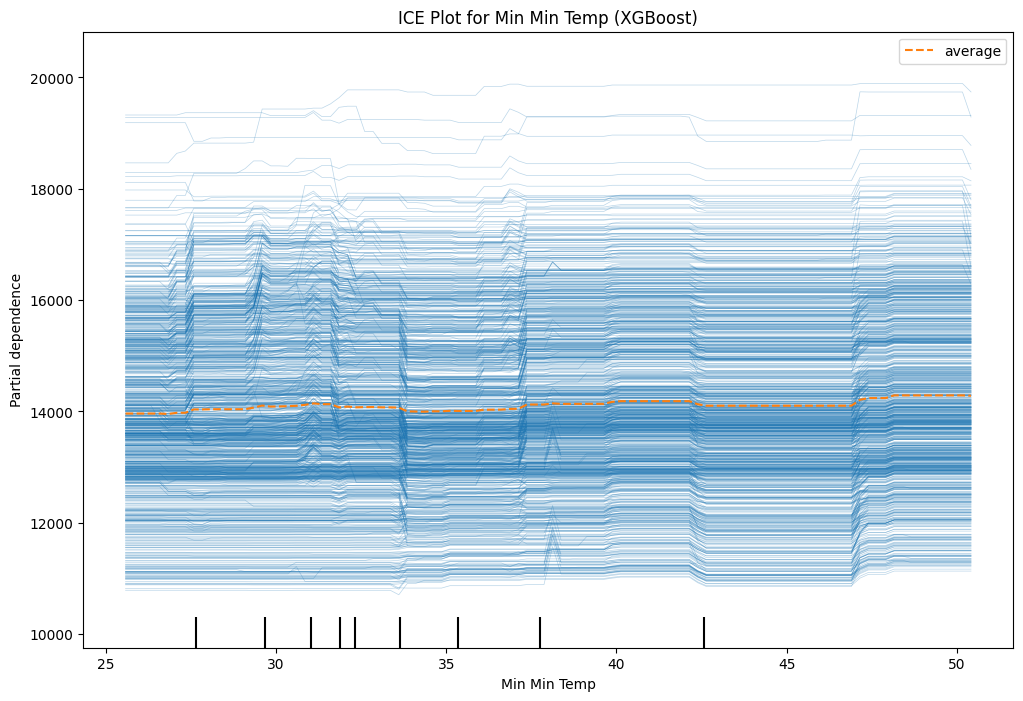

In [9]:
# ICE Plots for the top 5 features (Random Forest)
for feature in top_rf_features[:5]:
    fig, ax = plt.subplots(figsize=(12, 8))
    PartialDependenceDisplay.from_estimator(rf_grid_search.best_estimator_, X_train, features=[feature], kind="both", ax=ax)
    plt.title(f'ICE Plot for {feature} (Random Forest)')
    plt.show()

# ICE Plots for the top 5 features (XGBoost)
for feature in top_xgb_features[:5]:
    fig, ax = plt.subplots(figsize=(12, 8))
    PartialDependenceDisplay.from_estimator(xgb_grid_search.best_estimator_, X_train, features=[feature], kind="both", ax=ax)
    plt.title(f'ICE Plot for {feature} (XGBoost)')
    plt.show()

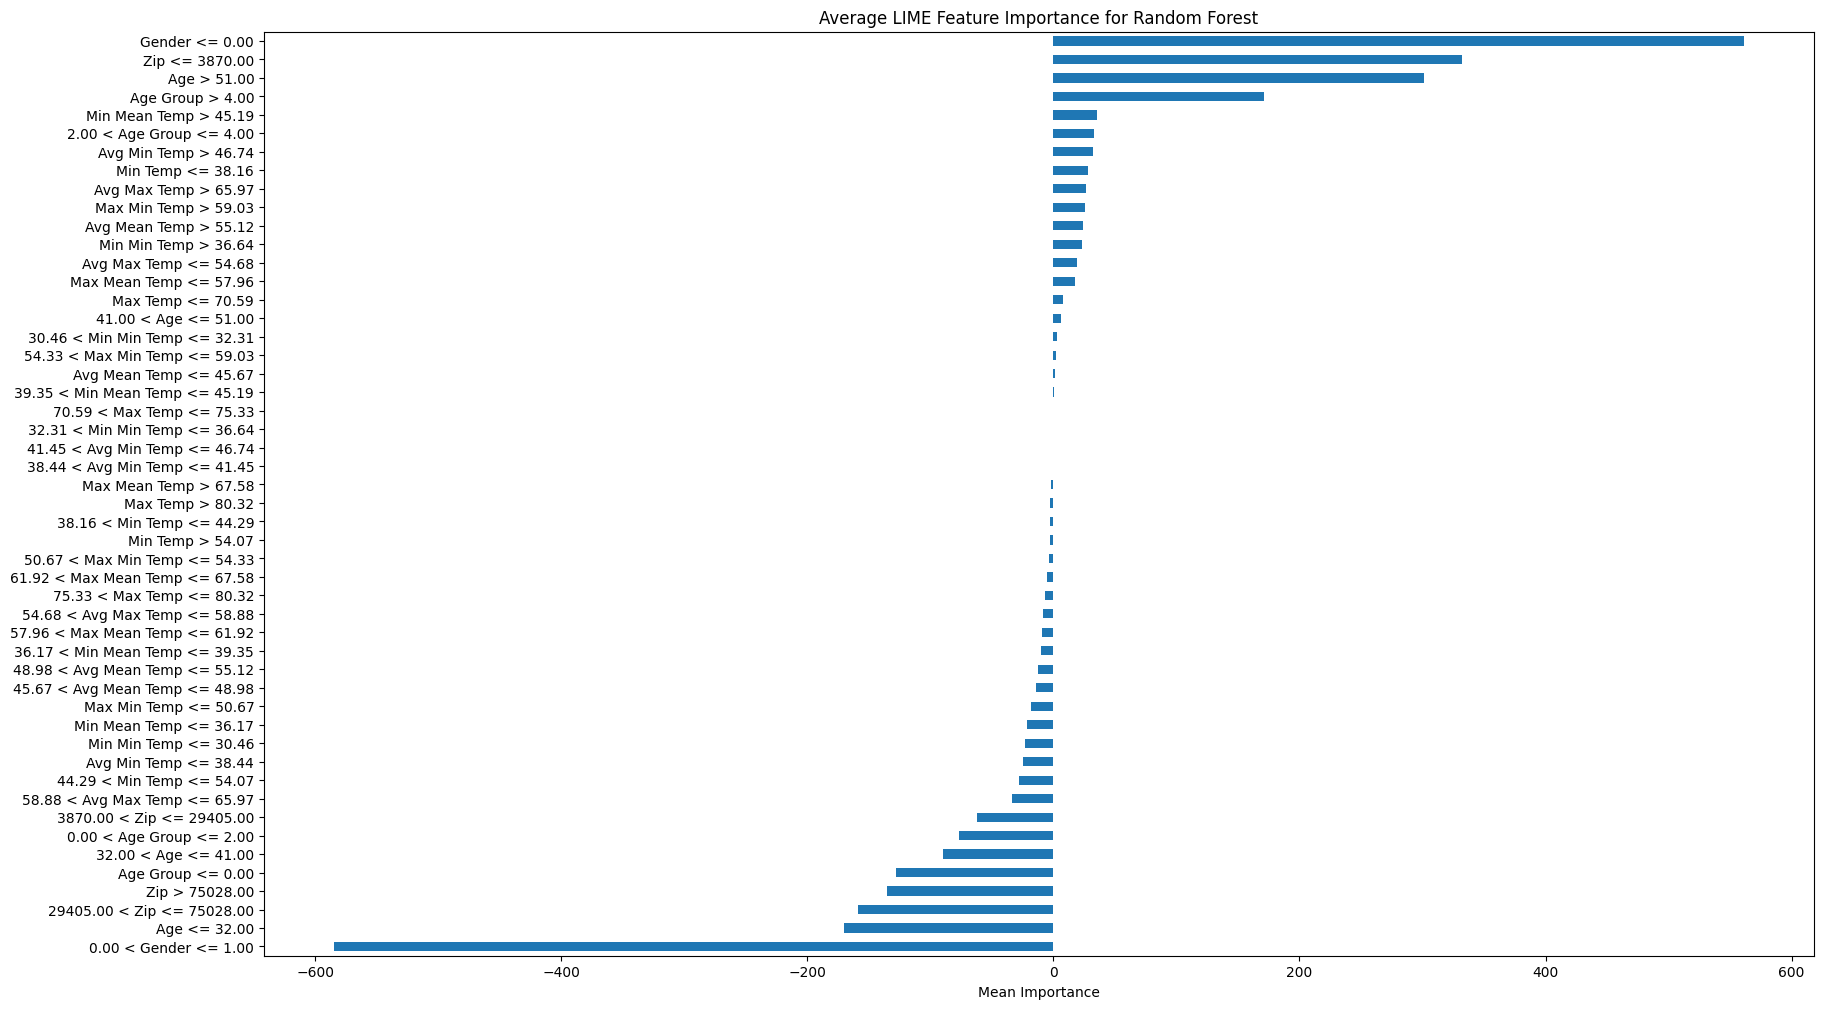

In [10]:
# LIME for explaining Random Forest predictions
explainer_rf = lime.lime_tabular.LimeTabularExplainer(X_train_df.values, feature_names=X_train_df.columns, class_names=['Finish'], 
                                                      discretize_continuous=True, mode='regression')

# Select multiple instances to explain
num_samples = 500  # Number of instances to explain
sample_indices = np.random.choice(range(X_test_df.shape[0]), num_samples, replace=False)
lime_explanations_rf = []

def rf_predict_proba(X):
    return np.array([rf_grid_search.predict(pd.DataFrame(X, columns=X_train_df.columns))]).T

for i in sample_indices:
    instance = X_test_df.values[i]
    exp = explainer_rf.explain_instance(instance, rf_predict_proba, num_features=10)
    lime_explanations_rf.append(exp)

# Aggregate feature importances for Random Forest
feature_importances_rf = pd.DataFrame([dict(exp.as_list()) for exp in lime_explanations_rf]).fillna(0)
mean_importances_rf = feature_importances_rf.mean().sort_values(ascending=False)

# Plot average LIME feature importances for Random Forest
plt.figure(figsize=(20, 12))
mean_importances_rf.plot(kind='barh')
plt.xlabel('Mean Importance')
plt.title('Average LIME Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.show()

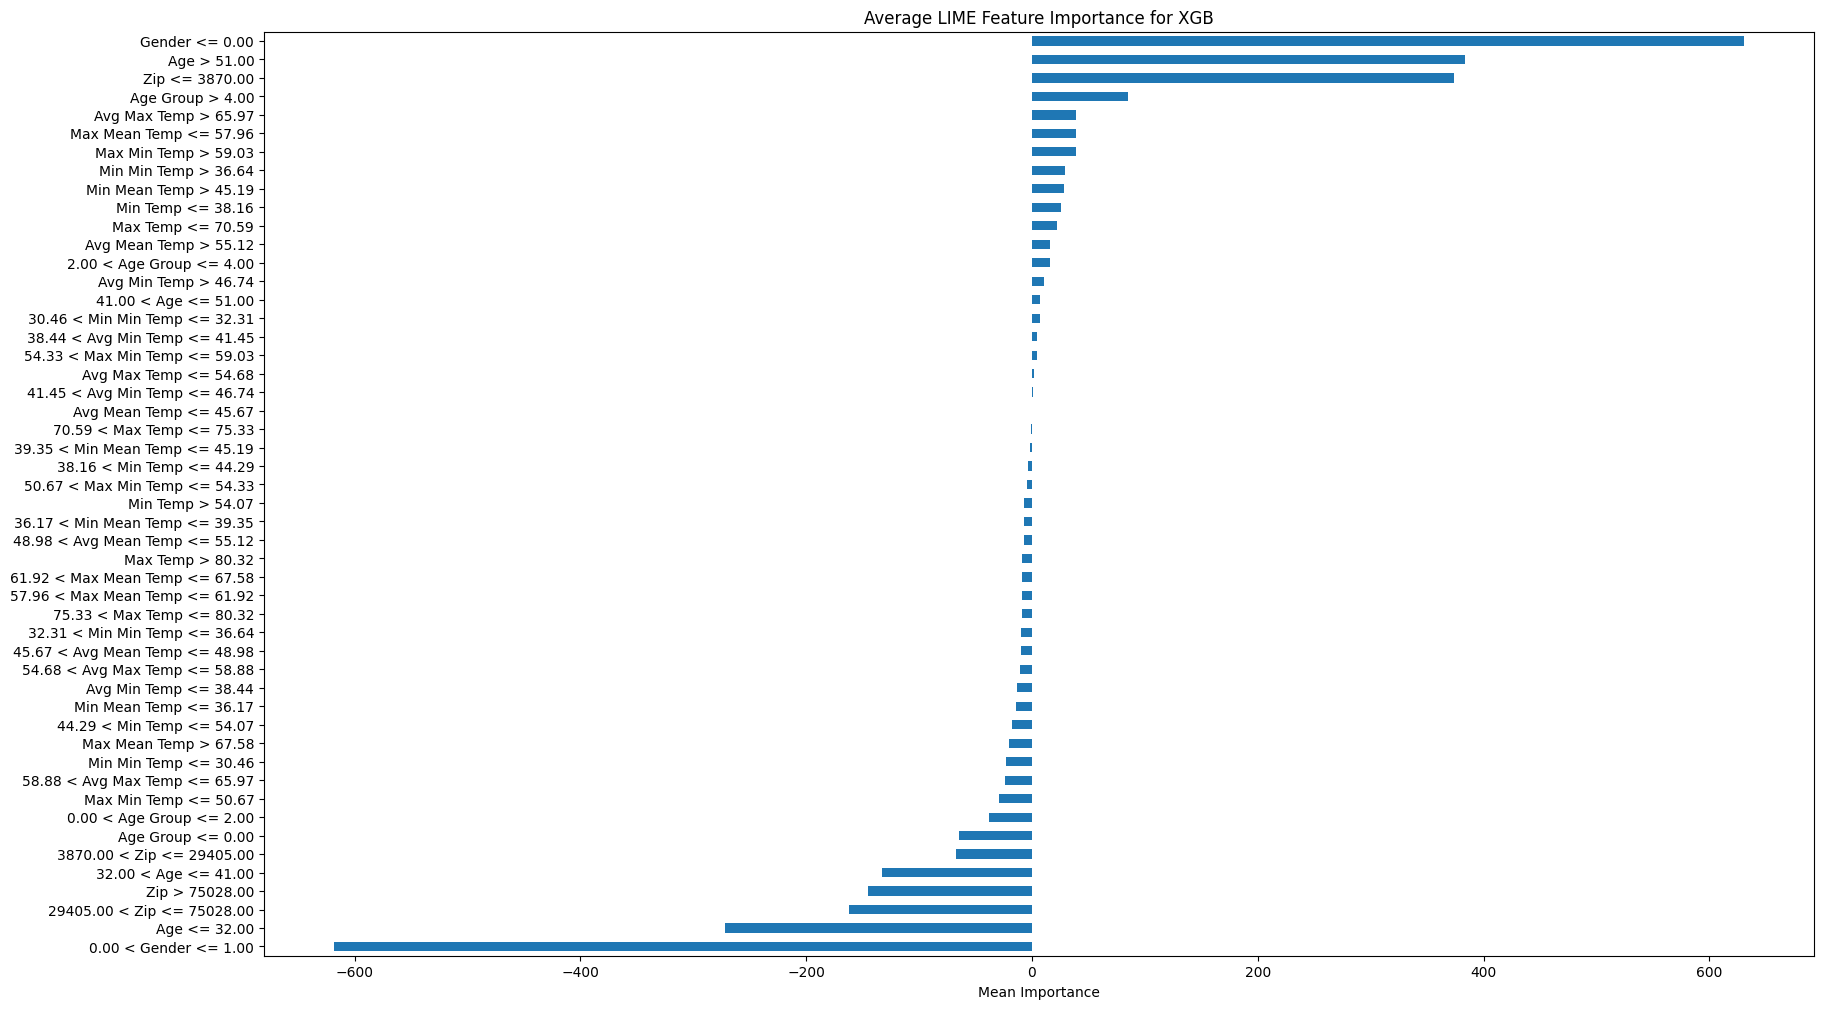

In [11]:
# LIME for explaining XGB predictions
explainer_xgb = lime.lime_tabular.LimeTabularExplainer(X_train_df.values, feature_names=X_train_df.columns, class_names=['Finish'], 
                                                       discretize_continuous=True, mode='regression')

# Select multiple instances to explain
num_samples = 500  # Number of instances to explain
sample_indices = np.random.choice(range(X_test_df.shape[0]), num_samples, replace=False)
lime_explanations_xgb = []

def xgb_predict_proba(X):
    return np.array([xgb_grid_search.predict(pd.DataFrame(X, columns=X_train_df.columns))]).T

for i in sample_indices:
    instance = X_test_df.values[i]
    exp = explainer_rf.explain_instance(instance, xgb_predict_proba, num_features=10)
    lime_explanations_rf.append(exp)

# Aggregate feature importances for XGB
feature_importances_xgb = pd.DataFrame([dict(exp.as_list()) for exp in lime_explanations_rf]).fillna(0)
mean_importances_xgb = feature_importances_xgb.mean().sort_values(ascending=False)

# Plot average LIME feature importances for XGB
plt.figure(figsize=(20, 12))
mean_importances_xgb.plot(kind='barh')
plt.xlabel('Mean Importance')
plt.title('Average LIME Feature Importance for XGB')
plt.gca().invert_yaxis()
plt.show()